## Задание:
Построить модель случайного леса для предсказагия качества вина из data set WineQT.csv.

In [ ]:
pip install bayesian-optimization

In [ ]:
!pip install openpyxl

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import openpyxl
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from bayes_opt import BayesianOptimization

In [ ]:
df=pd.read_csv('WineQT.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


Все признаки числовые, энкодинг не требуется

In [ ]:
df.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


Пропущенных значений в данных нету. Предварительную обработку проводить не надо.

##  EDA

In [ ]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


Признаки сильно отличаются по значениям в сотни раз друг от друга. Поэтому применим перед созданием модели StandardScaler стандартизацию к данным.

In [ ]:
df.drop('Id', axis=1, inplace=True) # Id никак не влияет на построение модели. Поэтому убираем столбец ID.

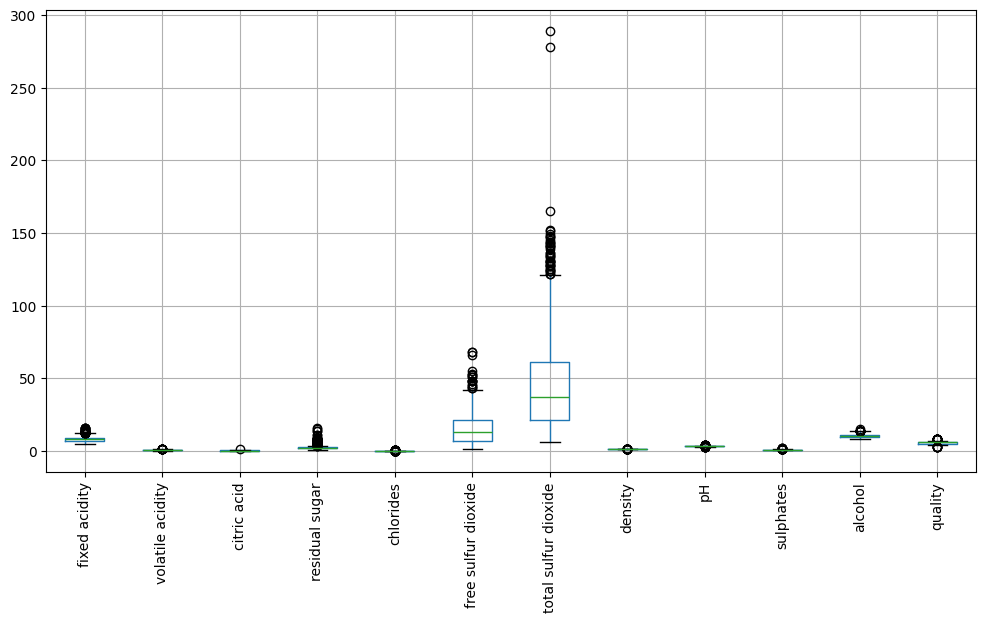

In [ ]:
df.boxplot(figsize=(12,6))
plt.xticks(rotation=90)
plt.show()

Выбросы в данных присутствуют, особенно в total sulfur dioxide, free sulfur dioxide и residual sugar. Однако эти данные получены инструментально в лаборатории. Убирать выбросы нельзя.

In [ ]:
df['quality'].value_counts()

,count
quality,
5,483
6,462
7,143
4,33
8,16
3,6


Классы не сбалансированы поэтому при разбиении будем применять stratify=y, а при обучении модели балансировку классов

In [ ]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

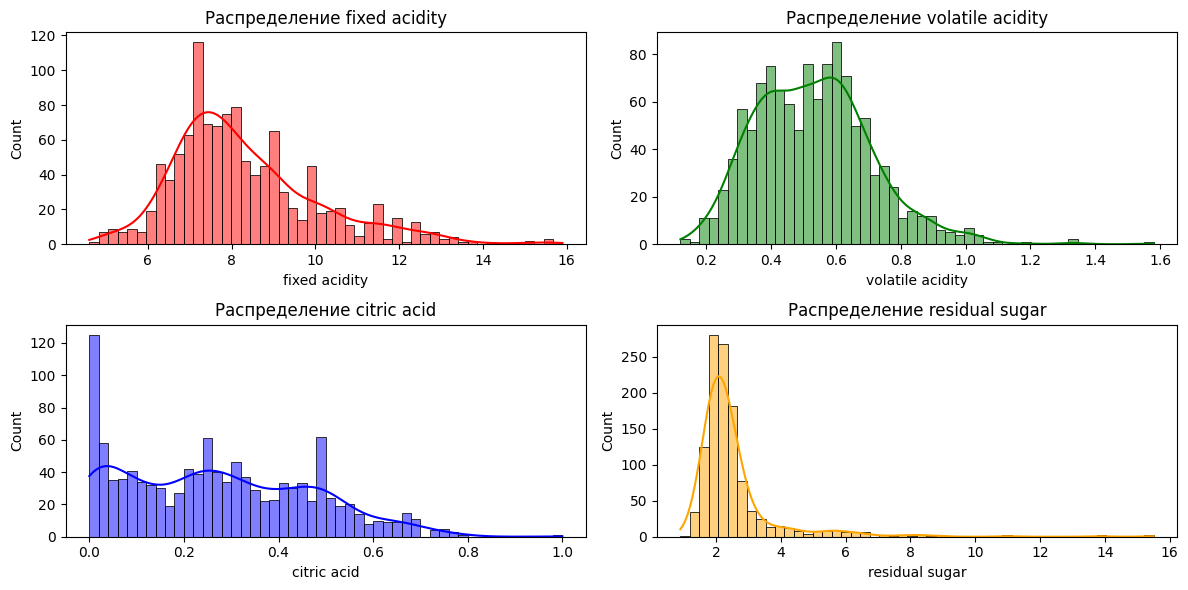

In [ ]:
def hist(plt=None, col='quality', colori='red'):
      sns.histplot(df[col], bins=50, kde=True, color=colori)
      plt.title(f'Распределение {col}')

def show_hist(columns_show=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar']):
      colors=['red', 'green', 'blue', 'orange']

      plt.figure(figsize=(12,6))
      for i, col in enumerate(columns_show):
          plt.subplot(2,2,i+1)
          def hist(plt=plt, col=col, colori=colors[i]):
            sns.histplot(df[col], bins=50, kde=True, color=colori)
            plt.title(f'Распределение {col}')

          hist(plt=plt, col=col, colori=colors[i])

      plt.tight_layout()
      plt.show()

show_hist()

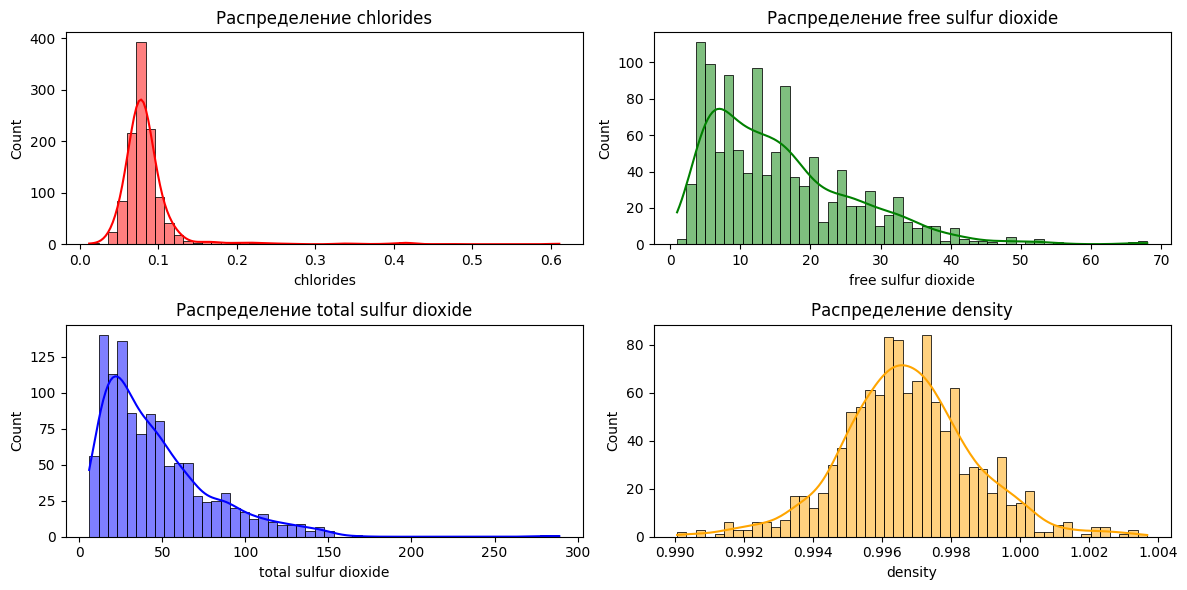

In [ ]:
show_hist(columns_show=['chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density'])

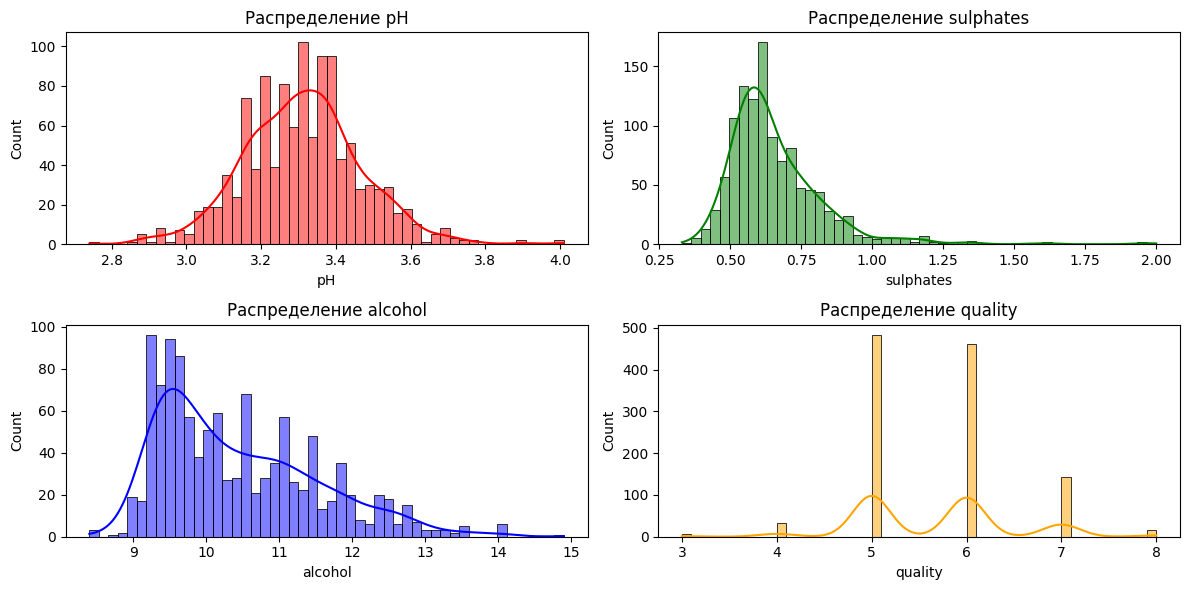

In [ ]:
show_hist(columns_show=['pH', 'sulphates', 'alcohol', 'quality'])

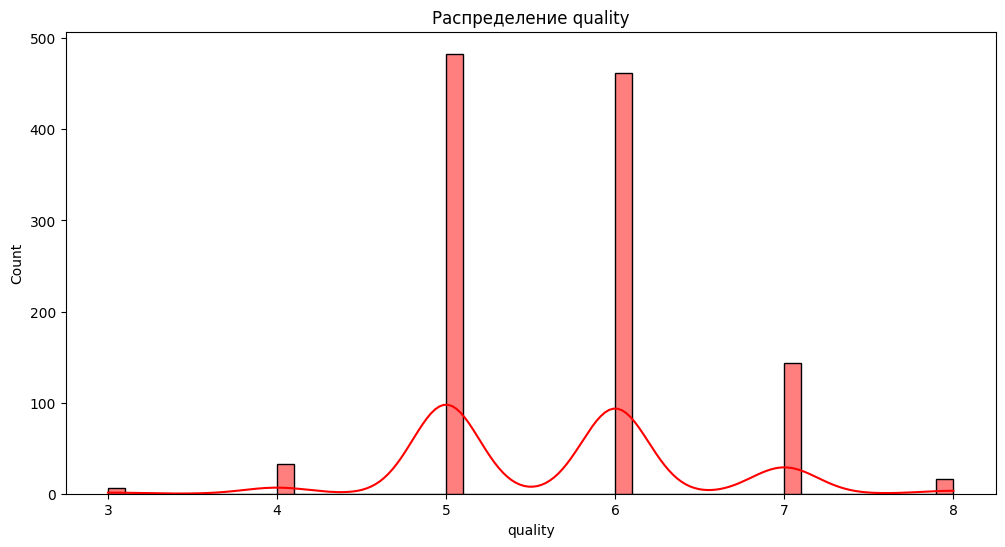

In [ ]:
plt.figure(figsize=(12,6))
hist(plt)

Распределение всех признаков и  классов далеки от нормальных.

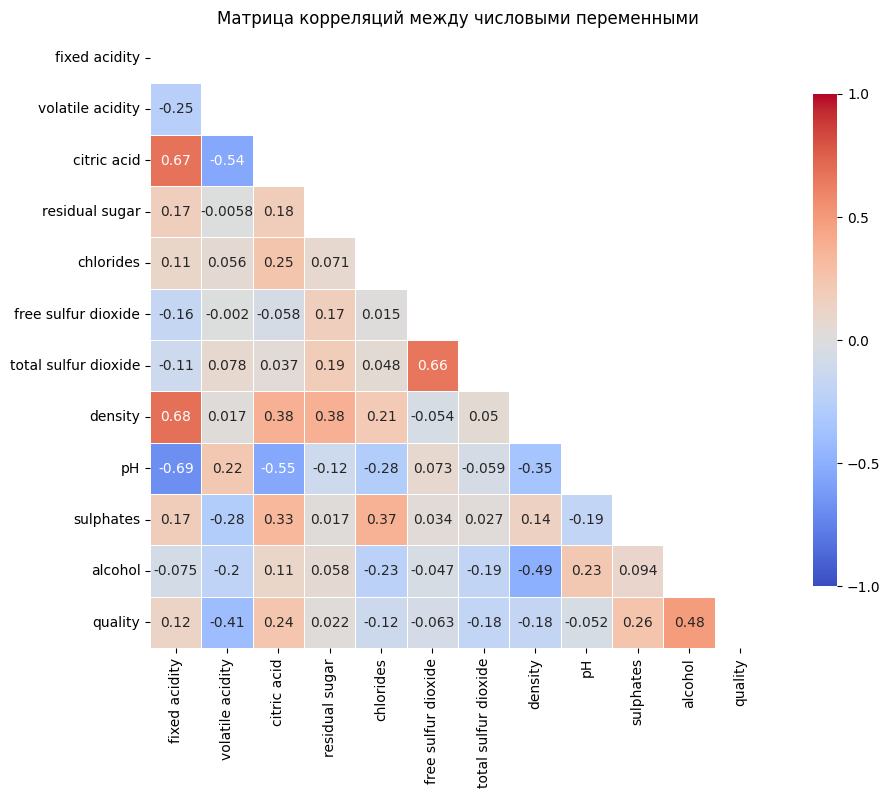

In [ ]:
correlation_matrix=df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot_kws={"size": 10},
            cbar_kws={"shrink": 0.8, "orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]})
plt.title('Матрица корреляций между числовыми переменными')
plt.show()

Больше всего влияет на качество вина содержание алкоголя и сульфатов. Вина вероятно оценивают по степени опьянения. Оценка качества скорее всего производилась on-line опросом, а не экспертами.

In [ ]:
X=df.drop('quality', axis=1)
y=df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Признаки не сбалансированы, применим stratify=y при разбиении
# Производим стандартизацию к признакам
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

## Поиск лучших гиперпараметров для ансабля деревьев RandomForestRegressor с помощью BayesianOptimization

In [ ]:
def random_forest_par(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):

    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=None if int(max_depth) == 0 else int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=float(max_features),
        class_weight='balanced', # Классы не сбалансированные поэтому применим балансировку
        random_state=42,
        n_jobs=-1
    )

    # Кросс-валидация
    scores = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=5) # Классы не сбалансированы применим f1_weighted
    # Возвращаем среднее значение RMSE
    return scores.mean()

# Определение пространства параметров для байесовской оптимизации
param_bounds = {
    'n_estimators': (50, 320),
    'max_depth': (0, 20),
    'min_samples_split': (2, 8),
    'min_samples_leaf': (1, 8),
    'max_features': (0.1, 1.0)  # Пропорция от числа признаков
}

optimizer = BayesianOptimization( f=random_forest_par, pbounds=param_bounds, random_state=42, verbose=2)

optimizer.maximize(init_points=10, n_iter=30)
best_params_rf = optimizer.max['params']
best_params_rf['n_estimators'] = int(best_params_rf['n_estimators'])
best_params_rf['max_depth'] = None if int(best_params_rf['max_depth']) == 0 else int(best_params_rf['max_depth'])
best_params_rf['min_samples_split'] = int(best_params_rf['min_samples_split'])
best_params_rf['min_samples_leaf'] = int(best_params_rf['min_samples_leaf'])
best_params_rf['max_features'] = float(best_params_rf['max_features'])


best_model_rf = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)

def calculate_model_show_best_params(best_model=best_model_rf, name_model='RandomForestClassifier'):
    best_model.fit(X_train, y_train)
    best_train_preds = best_model.predict(X_train)
    best_train_rmse = np.sqrt(mean_squared_error(y_train, best_train_preds))
    print(f"Лучшие параметры {name_model}: {best_params_rf}")
    print(f'Лучшие метрики модели {name_model}')
    print(f'Precision: {precision_score(y_train, best_train_preds, average="weighted")}')
    print(f'Recall: {recall_score(y_train, best_train_preds, average="weighted")}')
    print(f'F1-score: {f1_score(y_train, best_train_preds, average="weighted")}')

calculate_model_show_best_params()

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.5585    | 7.491     | 0.9556    | 6.124     | 5.592     | 92.13     |
| 2         | 0.4167    | 3.12      | 0.1523    | 7.063     | 5.607     | 241.2     |
| 3         | 0.5818    | 0.4117    | 0.9729    | 6.827     | 3.274     | 99.09     |
| 4         | 0.407     | 3.668     | 0.3738    | 4.673     | 4.592     | 128.6     |
| 5         | 0.6103    | 12.24     | 0.2255    | 3.045     | 4.198     | 173.1     |
| 6         | 0.5954    | 15.7      | 0.2797    | 4.6       | 5.554     | 62.54     |
| 7         | 0.6159    | 12.15     | 0.2535    | 1.455     | 7.693     | 310.7     |
| 8         | 0.6305    | 16.17     | 0.3742    | 1.684     | 6.105     | 168.8     |
| 9         | 0.3575    | 2.441     | 0.5457    | 1.241     | 7.456     | 119.9     |
| 10        | 0.5954    | 13.25     | 0.3805    | 4.64

Модель явно переобучилась, все метрики 1.

## Поиск лучших гиперпараметров для ансабля деревьев HistGradientBoostingClassifier с помощью BayesianOptimization

In [ ]:
def hist_gradient_boosting_classifier_par(max_iter, max_depth, min_samples_leaf, max_features, learning_rate):

    model =HistGradientBoostingClassifier(
        max_iter=int(max_iter),
        max_depth=None if int(max_depth) == 0 else int(max_depth),
        min_samples_leaf=int(min_samples_leaf),
        max_features=float(max_features),
        learning_rate=float(learning_rate),
        class_weight='balanced', # Классы не сбалансированные поэтому применим балансировку
        random_state=42
    )

    # Кросс-валидация
    scores = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=6) # Классы не сбалансированы применим f1_weighted
    # Возвращаем среднее значение RMSE
    return scores.mean()

# Определение пространства параметров для байесовской оптимизации
param_bounds = {
    'max_iter': (50, 250),
    'max_depth': (1, 32),
    'min_samples_leaf': (1, 8),
    'max_features': (0.1, 1.0),  # Пропорция от числа признаков
    'learning_rate': (0.01, 0.5)
}

optimizer = BayesianOptimization( f=hist_gradient_boosting_classifier_par, pbounds=param_bounds, random_state=42, verbose=2)

optimizer.maximize(init_points=2, n_iter=3)
best_params_gbr= optimizer.max['params']
best_params_gbr['max_iter'] = int(best_params_gbr['max_iter'])
best_params_gbr['max_depth'] = None if int(best_params_gbr['max_depth']) == 0 else int(best_params_gbr['max_depth'])
best_params_gbr['min_samples_leaf'] = int(best_params_gbr['min_samples_leaf'])
best_params_gbr['max_features'] = float(best_params_gbr['max_features'])
best_params_gbr['learning_rate'] = float(best_params_gbr['learning_rate'])


best_model_gbr = HistGradientBoostingClassifier(**best_params_gbr, random_state=42)

calculate_model_show_best_params(best_model=best_model_gbr, name_model='HistGradientBoostingClassifier')

|   iter    |  target   | learni... | max_depth | max_fe... | max_iter  | min_sa... |
-------------------------------------------------------------------------------------
| 1         | 0.6105    | 0.1935    | 30.47     | 0.7588    | 169.7     | 2.092     |
| 2         | 0.5567    | 0.08644   | 2.801     | 0.8796    | 170.2     | 5.957     |
| 3         | 0.6119    | 0.2508    | 31.24     | 0.3999    | 169.0     | 1.631     |
| 4         | 0.6233    | 0.1632    | 31.34     | 0.535     | 134.8     | 2.049     |
| 5         | 0.6204    | 0.1799    | 31.41     | 0.9371    | 102.3     | 3.205     |
Лучшие параметры HistGradientBoostingClassifier: {'max_depth': 19, 'max_features': 0.11535063749256008, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 237}
Лучшие метрики модели HistGradientBoostingClassifier
Precision: 1.0
Recall: 1.0
F1-score: 1.0


Модель явно переобучилась, все метрики 1.

# Оценка производительности моделей на тестовой выборке, используя метрики классификации, такие как точность, полнота и F1-мера.

In [ ]:

def evaluate_model(model_name='RandomForestClassifier', best_model=best_model_rf):
    test_preds = best_model.predict(X_test)
    print(f'{model_name} metrics')
    print(f'Precision: {precision_score(y_test, test_preds, average="weighted")}')
    print(f'Recall: {recall_score(y_test, test_preds, average="weighted")}')
    print(f'F1-score: {f1_score(y_test, test_preds, average="weighted")}')

evaluate_model()
print('\n\n\n')
evaluate_model(model_name='HistGradientBoostingClassifier', best_model=best_model_gbr)


RandomForestClassifier metrics
Precision: 0.6797156321995268
Recall: 0.7074235807860262
F1-score: 0.6845902793467703




HistGradientBoostingClassifier metrics
Precision: 0.6846610206872216
Recall: 0.6899563318777293
F1-score: 0.6806941209301189


Модели практически дают одинаковые резултьтаты по исследуемым метрикам на тестовых данных.

Сравнение результатов подобранной модели со стандартной реализацией случайного леса из библиотеки scikit-learn.

In [ ]:
model_standard_rf=RandomForestClassifier()
model_standard_rf.fit(X_train, y_train)
evaluate_model(model_name='Standard RandomForestClassifier', best_model=model_standard_rf)

Standard RandomForestClassifier metrics
Precision: 0.6907751091703057
Recall: 0.7248908296943232
F1-score: 0.7038320099828091


RandomForestClassifier со стандартными гиперпараметрами по метрикам практически ничем не отличается от подобранного автоматически и с ансамблями HistGradientBoostingClassifier.

Все модели показали хорошие метрики на тренировочных данных F1-score ~ 0.70. Однако необходимо убрать переобучение на тренировочных данных F1-score=1. Можно ещё дальше пробовать увеличивать количество деревьев и уменьшать максимальную глубину деревьев.